In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams["animation.html"] = "jshtml"

The top edge of the model has a Dirichlet BC allowing reflected waves off the surface. <br>
The left, right, and bottom of the model edges have an approximated Mur absorbing boundary condition [expand](https://scipython.com/blog/the-two-dimensional-wave-equation/). 

In [13]:
# Simple finite difference solver 
# Acoustic wave equation  p_tt = c^2 p_xx + src
# 2-D regular grid

nx = 200      # grid points in x
nz = 200      # grid points in z
nt = 1500      # number of time steps
dx = 10.0     # grid increment in x
dt = 0.001    # Time step
c0 = 3000.0   # velocity (can be an array)
isx = nx // 2  # source index x
isz = nz // 2  # source index z
ist = 100     # shifting of source time function
f0 = 100.0    # dominant frequency of source (Hz)
isnap = 10     # snapshot frequency
T = 1.0 / f0  # dominant period
nop = 5       # length of operator
sIdx = 0     # Start model index
if nop == 3:
    dw = 1
elif nop == 5:
    dw = 2


# Model type, available are "homogeneous", "fault_zone",
# "surface_low_velocity_zone", "random", "topography",
# "slab"
model_type = "basin"

# Receiver locations
irx = np.array([sIdx+40, sIdx+80, sIdx+100, sIdx+120, sIdx+160])
irz = np.array([25, 5, 25, 5, 5])
seis = np.zeros((len(irx), nt))

# Initialize pressure at different time steps and the second
# derivatives in each direction
p = np.zeros((nz, nx))
pold = np.zeros((nz, nx))
pnew = np.zeros((nz, nx))
pxx = np.zeros((nz, nx))
pzz = np.zeros((nz, nx))

# Initialize velocity model
c = np.zeros((nz, nx))

if model_type == "homogeneous":
    c += c0
elif model_type == "fault_zone":
    c += c0
    c[:, nx // 2 - 5: nx // 2 + 5] *= 0.8    
elif model_type == "surface_low_velocity_zone":
    c += c0
    c[1:10,:] *= 0.8
elif model_type == "random":
    pert = 0.4
    r = 2.0 * (np.random.rand(nz, nx) - 0.5) * pert
    c += c0 * (1 + r)   
elif model_type == "topography":
    c += c0
    c[0 : 10, 10 : 50] = 0                         
    c[0 : 10, 105 : 115] = 0                       
    c[0 : 30, 145 : 170] = 0
    c[10 : 40, 20 : 40]  = 0
    c[0 : 15, 50 : 105] *= 0.8    
elif model_type == "slab":
    c += c0
    c[110 : 125, 0 : 125] = 1.4 * c0
    for i in range(110, 180):
        c[i , i-5 : i + 15 ] = 1.4 * c0
elif model_type == "basin":
    c += c0
    w0 = 150
    rw0 = 0
    for ii in range(sIdx+25,sIdx+65,1):
        c[rw0,ii:ii+w0] = c[rw0,ii:ii+w0]/1.5
        w0 -= 2
        rw0 += 1
    w0 = 100
    rw0 = 0
    for ii in range(sIdx+50,sIdx+70,2):
        c[rw0,ii:ii+w0] = c[rw0,ii:ii+w0]/1.2
        w0 -= 4
        rw0 += 1
else:
    raise NotImplementedError
    
cmax = c.max()

# Source time function Gaussian, nt + 1 as we loose the last one by diff
src = np.empty(nt + 1)
for it in range(nt):
    src[it] = np.exp(-1.0 / T ** 2 * ((it - ist) * dt) ** 2)
# Take the first derivative
src = np.diff(src) / dt
src[nt - 1] = 0

v = max([np.abs(src.min()), np.abs(src.max())])

plt.ioff()
# Initialize animated plot
fig,ax = plt.subplots(figsize=(5,5))
image = ax.imshow(pnew[sIdx:sIdx+200,:200], interpolation="nearest",
                   vmin=-v, vmax=+v, cmap=plt.cm.RdBu,extent=[sIdx,sIdx+200,200,0])
# Plot the receivers
for x, z in zip(irx, irz):
    ax.text(x, z, "+")
ax.text(isx, isz, "o")
# ax.colorbar()
ax.set_xlabel("ix")
ax.set_ylabel("iz")


# required for seismograms
ir = np.arange(len(irx))

# Output Courant criterion
alpha = cmax*dt/dx
alpha2 = alpha**2
print(f"Courant Criterion eps : {alpha:.2f}")
kappa = (1 - alpha) / (1 + alpha)

pres_hist = []
pmax_hist = []


# Time extrapolation
for it in range(nt):
    if nop==3:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(dw, nx - dw):
            pzz[:, i] = p[:, i + 1] - 2 * p[:, i] + p[:, i - 1]
        for j in range(dw, nz - dw):
            pxx[j, :] = p[j - 1, :] - 2 * p[j, :] + p[j + 1, :]

    if nop==5:
        # calculate partial derivatives, be careful around the boundaries
        for i in range(dw, nx - dw):
            pzz[:, i] = -1./12*p[:,i+2]+4./3*p[:,i+1]-5./2*p[:,i]+4./3*p[:,i-1]-1./12*p[:,i-2]
        for j in range(dw, nz - dw):
            pxx[j, :] = -1./12*p[j+2,:]+4./3*p[j+1,:]-5./2*p[j,:]+4./3*p[j-1,:]-1./12*p[j-2,:]
                    
            
    pxx /= dx ** 2
    pzz /= dx ** 2

    # Time extrapolation
    pnew = 2 * p - pold + (dt ** 2) * (c ** 2) * (pxx + pzz)
    # Add source term at isx, isz
    pnew[isz, isx] = pnew[isz, isx] + src[it]

    # Apply Mur absorbing boundary conditions to the left,right, and bottom
    if nop==3:
        pnew[1:nz-1,0] = p[1:nz-1,1] - (kappa * (pnew[1:nz-1,1] - p[1:nz-1,0]))        # Left boundary
        pnew[1:nz-1,-1] = p[1:nz-1,-2] - (kappa * (pnew[1:nz-1,-2] - p[1:nz-1,-1]))    # Right boundary
        pnew[-1,1:nx-1] = p[-2,1:nx-1] - (kappa * (pnew[-2,1:nx-1] - p[-1,1:nx-1]))    # Bottom boundary
    if nop==5:
        pnew[dw:nz-dw,:2] = p[dw:nz-dw,1:3] - (kappa * (pnew[dw:nz-dw,1:3] - p[dw:nz-dw,:2]))          # Left boundary
        pnew[dw:nz-dw,-2:] = p[dw:nz-dw,-3:-1] - (kappa * (pnew[dw:nz-dw,-3:-1] - p[dw:nz-dw,-2:]))    # Right boundary
        pnew[-2:,dw:nx-dw] = p[-3:-1,dw:nx-dw] - (kappa * (pnew[-3:-1,dw:nx-dw] - p[-2:,dw:nx-dw]))    # Bottom boundary

    if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
        pres_hist.append(pnew)
        pmax_hist.append(p.max())

    pold, p = p, pnew

    # Save seismograms
    seis[ir, it] = p[irz[ir], irx[ir]]


if it % isnap == 0:    # you can change the speed of the plot by increasing the plotting interval
    pres_hist.append(pnew)
    pmax_hist.append(p.max())

# Animate the pressure fields
def update(itr):
    # ax.clear()
    ax.set_title(f"Iter {itr*isnap:.0f} | Max P: {pmax_hist[itr]:.2f}")
    image.set_array(pres_hist[itr][sIdx:sIdx+200,:200])
    return [image]

FuncAnimation(fig, update, frames=len(pres_hist), blit=False, repeat=False)#ani = 


Courant Criterion eps : 0.30


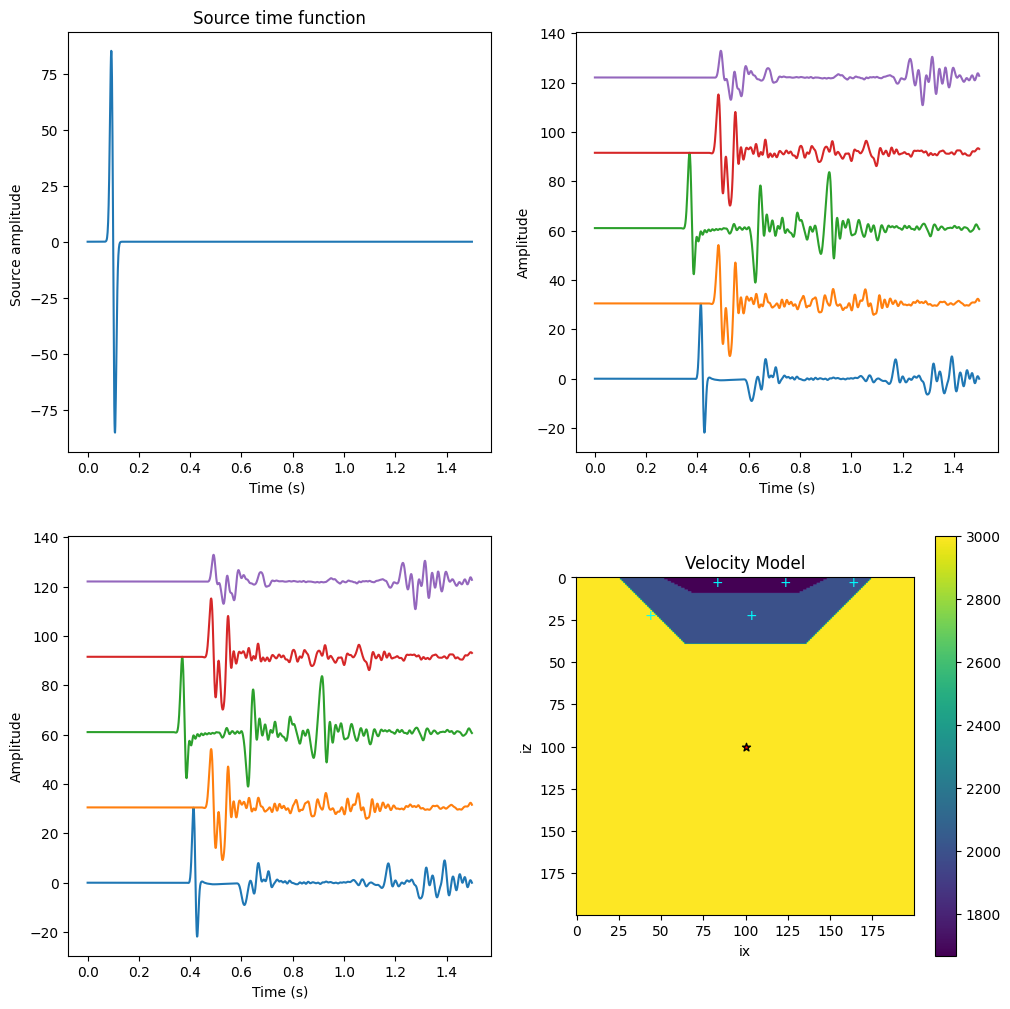

In [14]:
# Plot the source time function and the seismograms 
for i in range(500): plt.close()

plt.ioff()
plt.figure(figsize=(12, 12))

plt.subplot(221)
time = np.arange(nt) * dt
plt.plot(time, src)
plt.title('Source time function')
plt.xlabel('Time (s) ')
plt.ylabel('Source amplitude ')

plt.subplot(222)
ymax = seis.ravel().max()  
for ir in range(len(seis)):
    plt.plot(time, seis[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.subplot(223)
ymax = seis.ravel().max()
for ir in range(len(seis)):
    plt.plot(time, seis[ir, :] + ymax * ir)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.subplot(224)
# The velocity model is influenced by the Earth model above
plt.title('Velocity Model')
# Plot the receivers and source
for x, z in zip(irx, irz):
    plt.text(x, z, '+',c="cyan",zorder=2)
plt.scatter(isx, isz, marker='*', ec="k", c="r",zorder=2)
plt.imshow(c)
plt.xlabel('ix')
plt.ylabel('iz')
plt.colorbar()

plt.show()